<a href="https://colab.research.google.com/github/DMXMax/covid19/blob/gc_20200315/coviddata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests,json
import datetime


In [2]:
covidtrackingurl = "https://covidtracking.com/api/v1/states/daily.json"
response = requests.get(covidtrackingurl)
dfCovidtracking = pd.DataFrame(response.json())
dfCovidtracking.fillna(0, inplace=True)
dfCovidtracking.negative = dfCovidtracking.negative.astype('int64')
dfCovidtracking.positive = dfCovidtracking.positive.astype('int64')
dfCovidtracking.pending = dfCovidtracking.pending.astype('int64')
dfCovidtracking.total = dfCovidtracking.total.astype('int64')
dfCovidtracking.death = dfCovidtracking.death.astype('int64')

dfCovidtracking.date = dfCovidtracking.date.transform(lambda x: pd.to_datetime(datetime.date(x//10000, x%10000//100, x%100
                                          )))
dfCovidtracking.set_index(['date'], inplace=True)


In [3]:
dfWHO = pd.read_csv("https://raw.githubusercontent.com/DMXMax/covid19/master/who/who_data.tsv",
                     sep='\t', index_col='Date')

In [91]:
jhurl = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"+\
"csse_covid_19_data/csse_covid_19_daily_reports/06-15-2020.csv"


dfJHUData = pd.read_csv(jhurl, header=0, usecols=[0,1,2,3,4,5,6,7,8,9,10,11],
                        names=['FIPS', 'city','state', 'country', 'last_update',
                               'lat', 'lon','confirmed', 'dead', 'recovered','active', 'key'])

In [92]:
dfWHO = dfWHO.rename(columns={"Confirmed": "confirmed", "Deaths": "who_deaths"})
dfWHO.index.names=['date']


In [6]:
print("US Summary")
dfCovidtracking.groupby(by='date').sum()[-14:][['positive', 'death', 'positiveIncrease', 'deathIncrease']]

US Summary


,positive,death,positiveIncrease,deathIncrease
date,,,,
2020-06-03,1852601,101531,20189,969
2020-06-04,1873167,102407,20566,876
2020-06-05,1896157,103255,22990,848
2020-06-06,1918512,103972,22355,717
2020-06-07,1937819,104432,19307,460
2020-06-08,1954942,105087,17123,655
2020-06-09,1972108,105989,17166,902
2020-06-10,1992857,106867,20749,878
2020-06-11,2014880,107803,22023,936


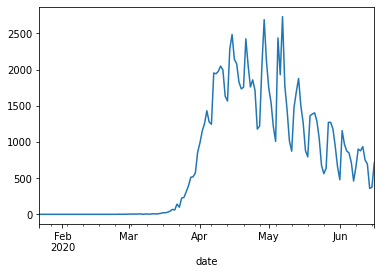

In [7]:
dfCovidtracking.groupby(by='date').sum().deathIncrease.plot.line()

In [8]:
dfCovidtracking.loc[dfCovidtracking.state=='CA'].groupby(by='date').sum()[['positive', 'death', 'positiveIncrease', 'deathIncrease']].tail()

,positive,death,positiveIncrease,deathIncrease
date,,,,
2020-06-12,141983,4943,2702,62
2020-06-13,145643,4989,3660,46
2020-06-14,148855,5063,3212,74
2020-06-15,151452,5089,2597,26
2020-06-16,153560,5121,2108,32


In [9]:
dfctd_state_curr = dfCovidtracking.loc[dfCovidtracking.index.max()] \
  .rename(columns={'positive':'total_positive'}) \
  .set_index('state') 

print(f"Total positive cases = {dfctd_state_curr.total_positive.sum()}")
print(f"Total deaths = {dfctd_state_curr.death.sum()}")
  
dfctd_state_curr.sort_values(by='total_positive', ascending=False).head(5)

Total positive cases = 2127047
Total deaths = 110695


,total_positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,dateModified,checkTimeEt,death,hospitalized,dateChecked,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,fips,positiveIncrease,negativeIncrease,total,totalTestResults,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NY,384575,2667203,0,1538.0,89995.0,449.0,0.0,303.0,0.0,68938.0,A,6/16/2020 00:00,2020-06-16T00:00:00Z,06/15 20:00,24608,89995.0,2020-06-16T00:00:00Z,0.0,0.0,0.0,384575.0,36,631,59937,3051778,3051778,60568,3051778,29,0,7278f5d47d05271633bcff6507a1313ce68703a7,0,0,0,0,0,
NJ,167426,964356,0,1291.0,18879.0,362.0,0.0,245.0,0.0,28872.0,A+,6/16/2020 13:00,2020-06-16T13:00:00Z,06/16 09:00,12727,18879.0,2020-06-16T13:00:00Z,0.0,0.0,0.0,167426.0,34,323,15376,1131782,1131782,15699,1131782,51,124,293ffef6d15b83b9ae6935e04c7bb15359ecae4c,0,0,0,0,0,
CA,153560,2784195,0,4462.0,0.0,1272.0,0.0,0.0,0.0,0.0,B,6/16/2020 00:00,2020-06-16T00:00:00Z,06/15 20:00,5121,0.0,2020-06-16T00:00:00Z,2937755.0,0.0,0.0,153560.0,06,2108,67465,2937755,2937755,69573,2937755,32,0,197ed439c7319257cbb5ccd48da4e0e5f364d387,0,0,0,0,0,
IL,134500,1094702,0,1939.0,0.0,561.0,0.0,331.0,0.0,0.0,A,6/16/2020 00:00,2020-06-16T00:00:00Z,06/15 20:00,6579,0.0,2020-06-16T00:00:00Z,1228341.0,0.0,0.0,133639.0,17,623,18106,1229202,1229202,18729,1229202,72,0,f517042d29b1ca608203df462314a1b2edf4f7a5,0,0,0,0,0,
MA,105885,617762,0,1045.0,10867.0,244.0,0.0,151.0,0.0,0.0,A+,6/16/2020 10:00,2020-06-16T10:00:00Z,06/16 06:00,7665,10867.0,2020-06-16T10:00:00Z,903422.0,0.0,0.0,101474.0,25,195,6221,723647,723647,6416,723647,18,50,213ec2f47a273cf2e3b3594cdc67924e566067bb,0,0,0,0,0,


In [10]:
curr_state = 'CA'
gbUSA = dfCovidtracking.groupby(['date'])
gbState = dfCovidtracking[dfCovidtracking.state==curr_state].groupby(['date'])

cols = ['positive', 'totalTestResultsIncrease', 'death', 'positiveIncrease','deathIncrease']

dfUSAPos = gbUSA[cols].sum().reset_index().copy()
dfStatePos = gbState[cols].sum().reset_index().copy()

#This will calculate the percentage each day is of the total. In a flattening, this will be more even
# In a high growth situation, you'll higher percentages at the tail. 

dfUSAPos['pos_pct']= dfUSAPos.positive/dfctd_state_curr.total_positive.sum()
dfStatePos['pos_pct']=dfStatePos.positive/dfctd_state_curr.loc[curr_state].total_positive

In [11]:
dfUSAPos[-7:]

,date,positive,totalTestResultsIncrease,death,positiveIncrease,deathIncrease,pos_pct
140,2020-06-10,1992857,422704,106867,20749,878,0.936913
141,2020-06-11,2014880,448120,107803,22023,936,0.947266
142,2020-06-12,2038198,583418,108554,23318,751,0.958229
143,2020-06-13,2063542,519910,109249,25344,695,0.970144
144,2020-06-14,2085028,485082,109607,21486,358,0.980245
145,2020-06-15,2103549,449488,109982,18521,375,0.988953
146,2020-06-16,2127047,464715,110695,23498,713,1.000000


In [12]:
dfStatePos[-7:]

,date,positive,totalTestResultsIncrease,death,positiveIncrease,deathIncrease,pos_pct
98,2020-06-10,136191,54553,4776,2702,79,0.886891
99,2020-06-11,139281,56849,4881,3090,105,0.907014
100,2020-06-12,141983,64611,4943,2702,62,0.924609
101,2020-06-13,145643,62135,4989,3660,46,0.948444
102,2020-06-14,148855,77603,5063,3212,74,0.969361
103,2020-06-15,151452,66186,5089,2597,26,0.986272
104,2020-06-16,153560,69573,5121,2108,32,1.000000


In [13]:
gbUSA.sum()[-5:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,positiveIncrease,negativeIncrease,total,totalTestResults,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,commercialScore,negativeRegularScore,negativeScore,positiveScore,score
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-06-12,2038198,20491914,1783,28524.0,223281.0,6012.0,9373.0,2734.0,814.0,547386.0,108554,223281.0,12276363.0,316795.0,4169383.0,1920996.0,23318,560100,22531895,22530112,583418,22530112,751,1298,0,0,0,0,0
2020-06-13,2063542,20986480,1698,27902.0,224420.0,5878.0,9430.0,2726.0,830.0,556606.0,109249,224420.0,12540209.0,323040.0,4246449.0,1948047.0,25344,494566,23051720,23050022,519910,23050022,695,1139,0,0,0,0,0
2020-06-14,2085028,21450076,1672,27247.0,225061.0,5743.0,9466.0,2716.0,834.0,561816.0,109607,225061.0,12820615.0,329060.0,4342741.0,1965081.0,21486,463596,23536776,23535104,485082,23535104,358,641,0,0,0,0,0
2020-06-15,2103549,21881043,1619,27115.0,225570.0,5695.0,9516.0,2636.0,835.0,576334.0,109982,225570.0,13059940.0,333626.0,4409610.0,1982161.0,18521,430967,23986211,23984592,449488,23984592,375,509,0,0,0,0,0
2020-06-16,2127047,22322260,1604,28028.0,226926.0,5564.0,9590.0,2594.0,845.0,583503.0,110695,226926.0,14228625.0,340308.0,4486786.0,2001434.0,23498,441217,24450911,24449307,464715,24449307,713,1356,0,0,0,0,0


In [14]:
gbState.sum()[-5:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,positiveIncrease,negativeIncrease,total,totalTestResults,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,commercialScore,negativeRegularScore,negativeScore,positiveScore,score
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-06-12,141983,2520275,0,4480.0,0.0,1310.0,0.0,0.0,0.0,0.0,4943,0.0,2662258.0,0.0,0.0,141983.0,2702,61909,2662258,2662258,64611,2662258,62,0,0,0,0,0,0
2020-06-13,145643,2578750,0,4411.0,0.0,1313.0,0.0,0.0,0.0,0.0,4989,0.0,2724393.0,0.0,0.0,145643.0,3660,58475,2724393,2724393,62135,2724393,46,0,0,0,0,0,0
2020-06-14,148855,2653141,0,4247.0,0.0,1280.0,0.0,0.0,0.0,0.0,5063,0.0,2801996.0,0.0,0.0,148855.0,3212,74391,2801996,2801996,77603,2801996,74,0,0,0,0,0,0
2020-06-15,151452,2716730,0,4323.0,0.0,1270.0,0.0,0.0,0.0,0.0,5089,0.0,2868182.0,0.0,0.0,151452.0,2597,63589,2868182,2868182,66186,2868182,26,0,0,0,0,0,0
2020-06-16,153560,2784195,0,4462.0,0.0,1272.0,0.0,0.0,0.0,0.0,5121,0.0,2937755.0,0.0,0.0,153560.0,2108,67465,2937755,2937755,69573,2937755,32,0,0,0,0,0,0


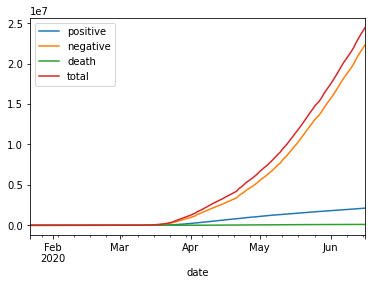

In [15]:
x=gbUSA.sum().loc[:, ['positive', 'negative','death','total']].plot.line()

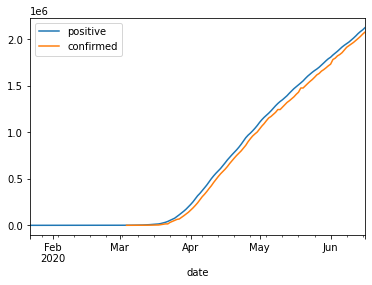

In [16]:
dfResults = gbUSA.sum().join(dfWHO, how='left', rsuffix='_who' )
dfResults.loc[:, ['positive', 'confirmed']].plot.line()

# John Hopkins Data


In [93]:
dfData = dfJHUData[dfJHUData.country=='US'][['confirmed', 'dead']].sum()
print(dfData)
print(f"IFR based on JHU Data: {dfData.dead/dfData.confirmed*100:.2f}%")

confirmed    2114026
dead          116127
dtype: int64
IFR based on JHU Data: 5.49%


In [94]:
dfJHUData[(dfJHUData.country=='US')&(dfJHUData.state=='California')][['confirmed', 'dead']].sum()

confirmed    155726
dead           5114
dtype: int64

In [19]:
dfJHUUS = dfJHUData[dfJHUData.country=='US']
gbJHUByState= dfJHUUS.groupby(by='state')
gbJHUByCountry = dfJHUData.groupby(by='country')

In [20]:
dfJHUData.head()

,FIPS,city,state,country,last_update,lat,lon,confirmed,dead,recovered,active,key
0,45001.0,Abbeville,South Carolina,US,2020-06-15 03:33:14,34.223334,-82.461707,67,0,0,67,"Abbeville, South Carolina, US"
1,22001.0,Acadia,Louisiana,US,2020-06-15 03:33:14,30.295065,-92.414197,583,31,0,552,"Acadia, Louisiana, US"
2,51001.0,Accomack,Virginia,US,2020-06-15 03:33:14,37.767072,-75.632346,993,14,0,979,"Accomack, Virginia, US"
3,16001.0,Ada,Idaho,US,2020-06-15 03:33:14,43.452658,-116.241552,892,22,0,870,"Ada, Idaho, US"
4,19001.0,Adair,Iowa,US,2020-06-15 03:33:14,41.330756,-94.471059,11,0,0,11,"Adair, Iowa, US"


In [21]:
gbJHUByCountry.confirmed.sum().sort_values(ascending=False).head(10)

country
US                2094058
Brazil             867624
Russia             528267
India              320922
United Kingdom     297342
Spain              243928
Italy              236989
Peru               229736
France             194153
Germany            187518
Name: confirmed, dtype: int64

In [22]:
dfctd_state_curr.head()

,total_positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,dateModified,checkTimeEt,death,hospitalized,dateChecked,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,fips,positiveIncrease,negativeIncrease,total,totalTestResults,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AK,676,75539,0,22.0,0.0,0.0,0.0,2.0,0.0,429.0,A,6/16/2020 00:00,2020-06-16T00:00:00Z,06/15 20:00,12,0.0,2020-06-16T00:00:00Z,76215.0,0.0,0.0,0.0,02,12,1766,76215,76215,1778,76215,0,0,9ce63702a549318053a366a0ef2d97680c2e6bad,0,0,0,0,0,
AL,26912,278512,0,678.0,2315.0,0.0,682.0,0.0,399.0,13508.0,B,6/16/2020 11:00,2020-06-16T11:00:00Z,06/16 07:00,785,2315.0,2020-06-16T11:00:00Z,0.0,0.0,0.0,26524.0,01,640,2110,305424,305424,2750,305424,11,56,e76cb0a1b1984ba8a95f80bd42da175e42add663,0,0,0,0,0,
AR,13191,192375,0,214.0,1026.0,0.0,0.0,45.0,165.0,8352.0,A,6/16/2020 15:10,2020-06-16T15:10:00Z,06/16 11:10,182,1026.0,2020-06-16T15:10:00Z,0.0,0.0,0.0,13191.0,05,274,1154,205566,205566,1428,205566,0,23,c5119ffd6425362da168a79b9b64af5bedc77ae3,0,0,0,0,0,
AS,0,174,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C,6/1/2020 00:00,2020-06-01T00:00:00Z,05/31 20:00,0,0.0,2020-06-01T00:00:00Z,0.0,0.0,0.0,0.0,60,0,0,174,174,0,174,0,0,913e72feb6ea7bfd2ac7d7c13e429b795093f1ed,0,0,0,0,0,
AZ,39097,315237,0,1506.0,3808.0,502.0,0.0,340.0,0.0,6598.0,A+,6/16/2020 00:00,2020-06-16T00:00:00Z,06/15 20:00,1219,3808.0,2020-06-16T00:00:00Z,353991.0,0.0,0.0,38754.0,04,2392,6685,354334,354334,9077,354334,25,58,8dcc29a1345dc796f33bc350b18f954733a928be,0,0,0,0,0,


In [23]:
dfState = dfCovidtracking.reset_index()[['date','state','positive', 'death']].set_index('state') \
  .join(dfctd_state_curr.total_positive)

In [24]:
dfState['pct']=dfState.positive/dfState.total_positive

In [25]:
dfState.loc['HI'].head(14)


,date,positive,death,total_positive,pct
state,,,,,
HI,2020-06-16,736,17,736,1.000000
HI,2020-06-15,728,17,736,0.989130
HI,2020-06-14,723,17,736,0.982337
HI,2020-06-13,706,17,736,0.959239
HI,2020-06-12,692,17,736,0.940217
HI,2020-06-11,685,17,736,0.930707
HI,2020-06-10,682,17,736,0.926630
HI,2020-06-09,676,17,736,0.918478
HI,2020-06-08,675,17,736,0.917120


In [26]:
res = dfState.reset_index().pivot(index = 'date', columns='state', values='pct').fillna(0)

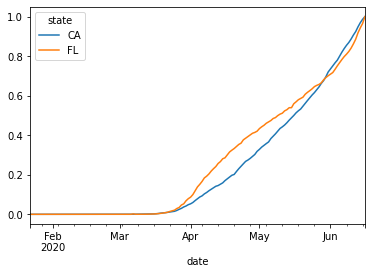

In [27]:
x = res.loc[:, ['CA','FL']].plot.line()

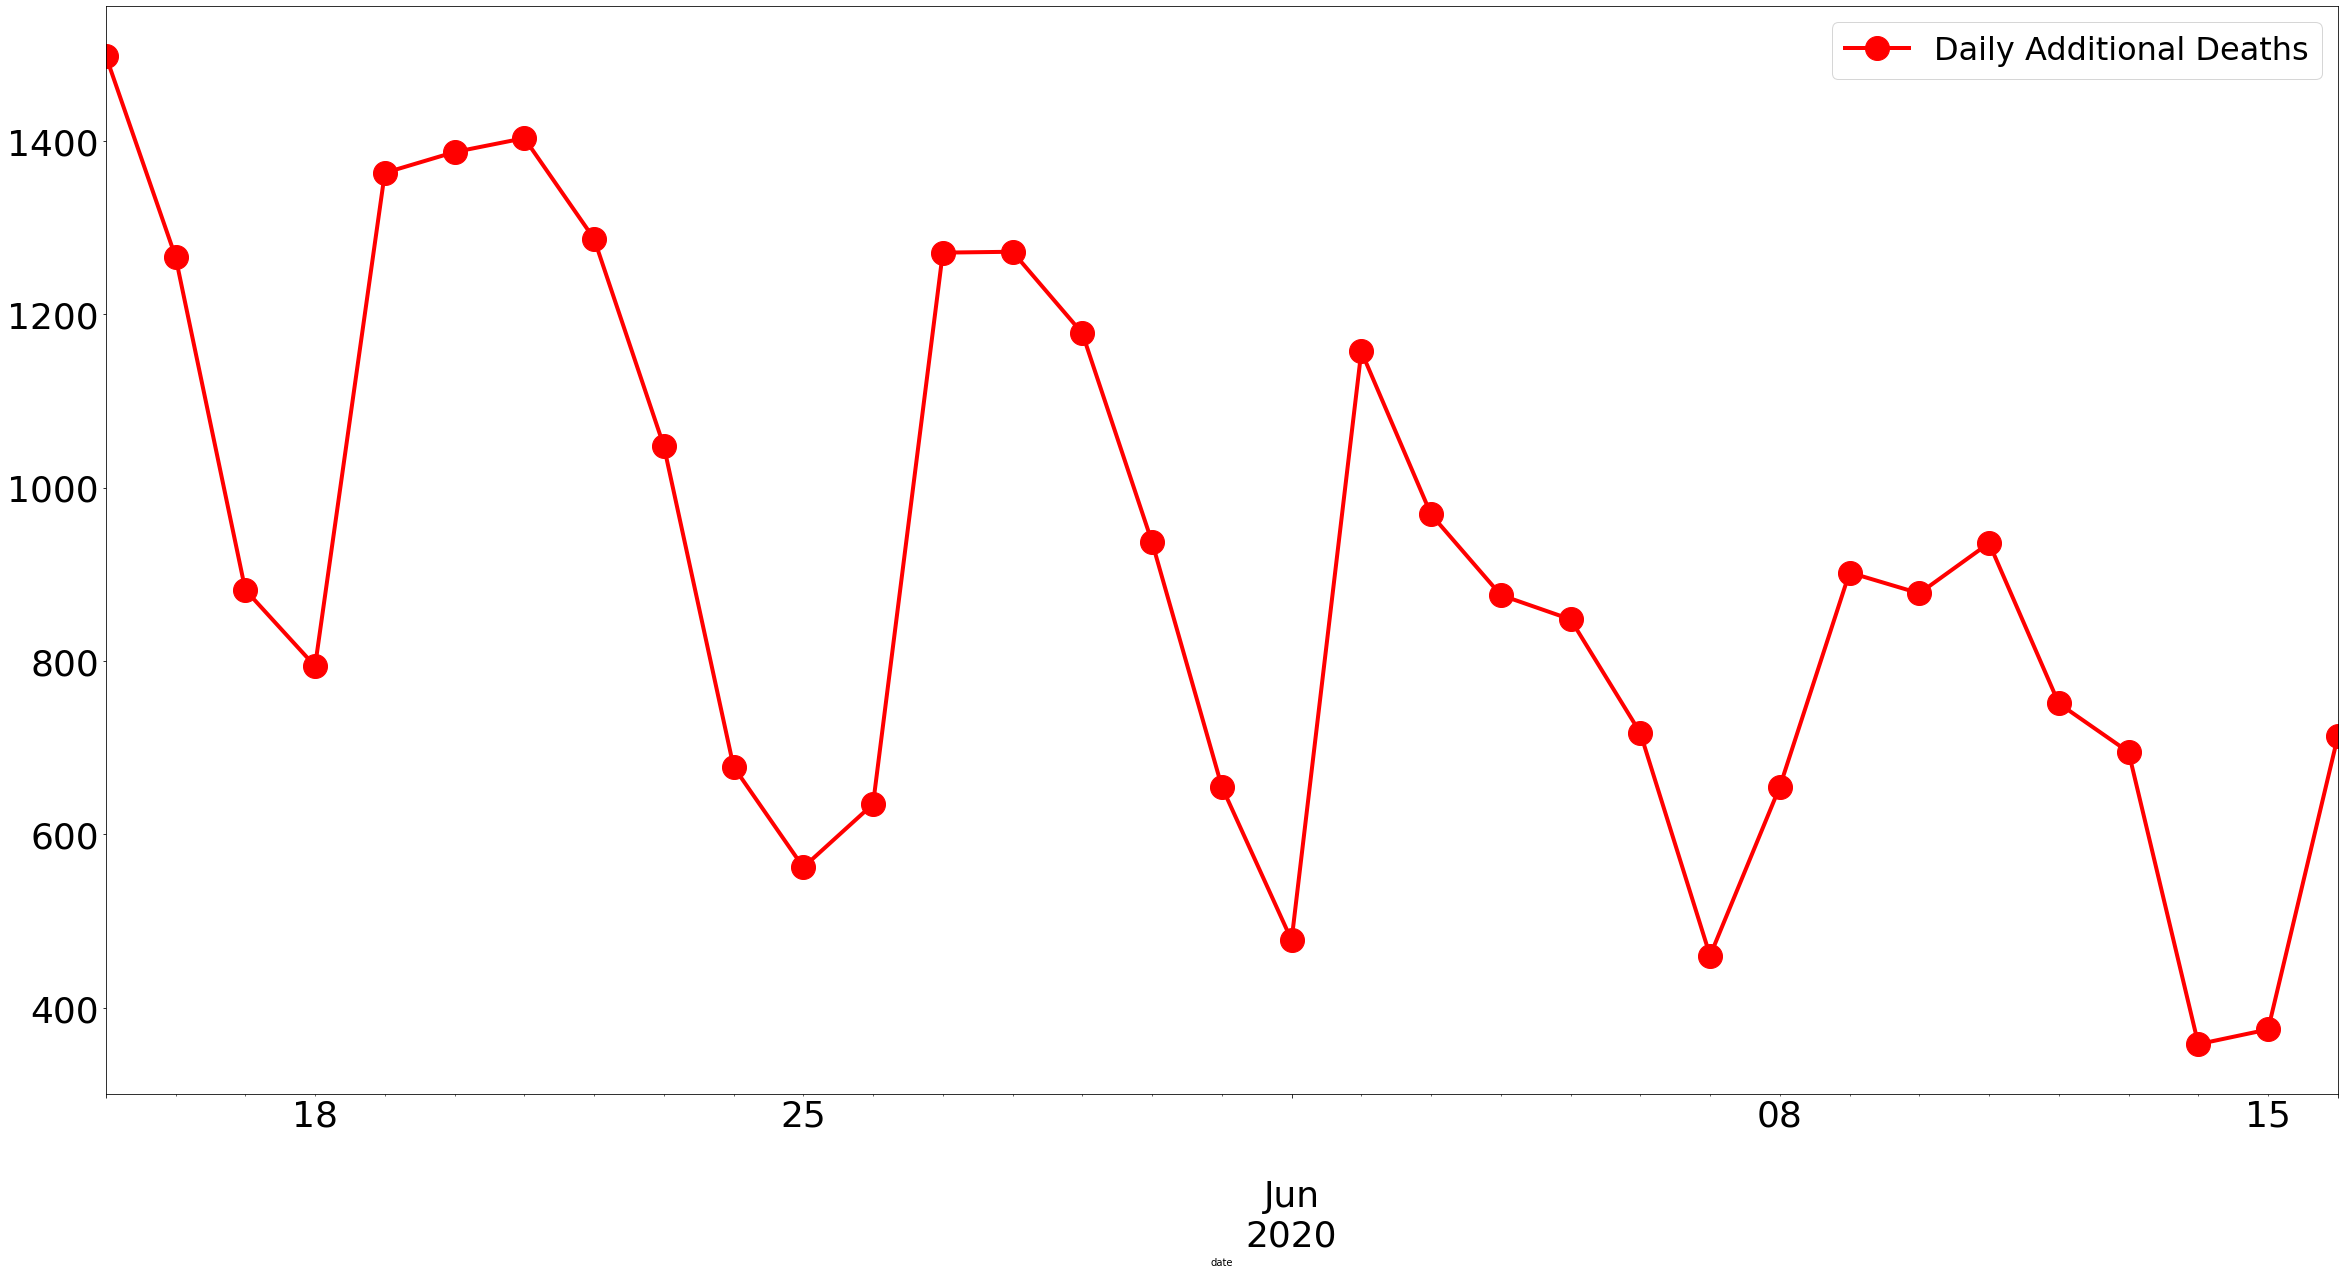

In [28]:
x = dfCovidtracking.groupby(by='date')
y1=x.sum()[-33:].deathIncrease.plot.line(figsize=(40,20), fontsize=36, \
  style='.-', markersize=48, color='red', linewidth=4) \
.legend(['Daily Additional Deaths'],fontsize=32)


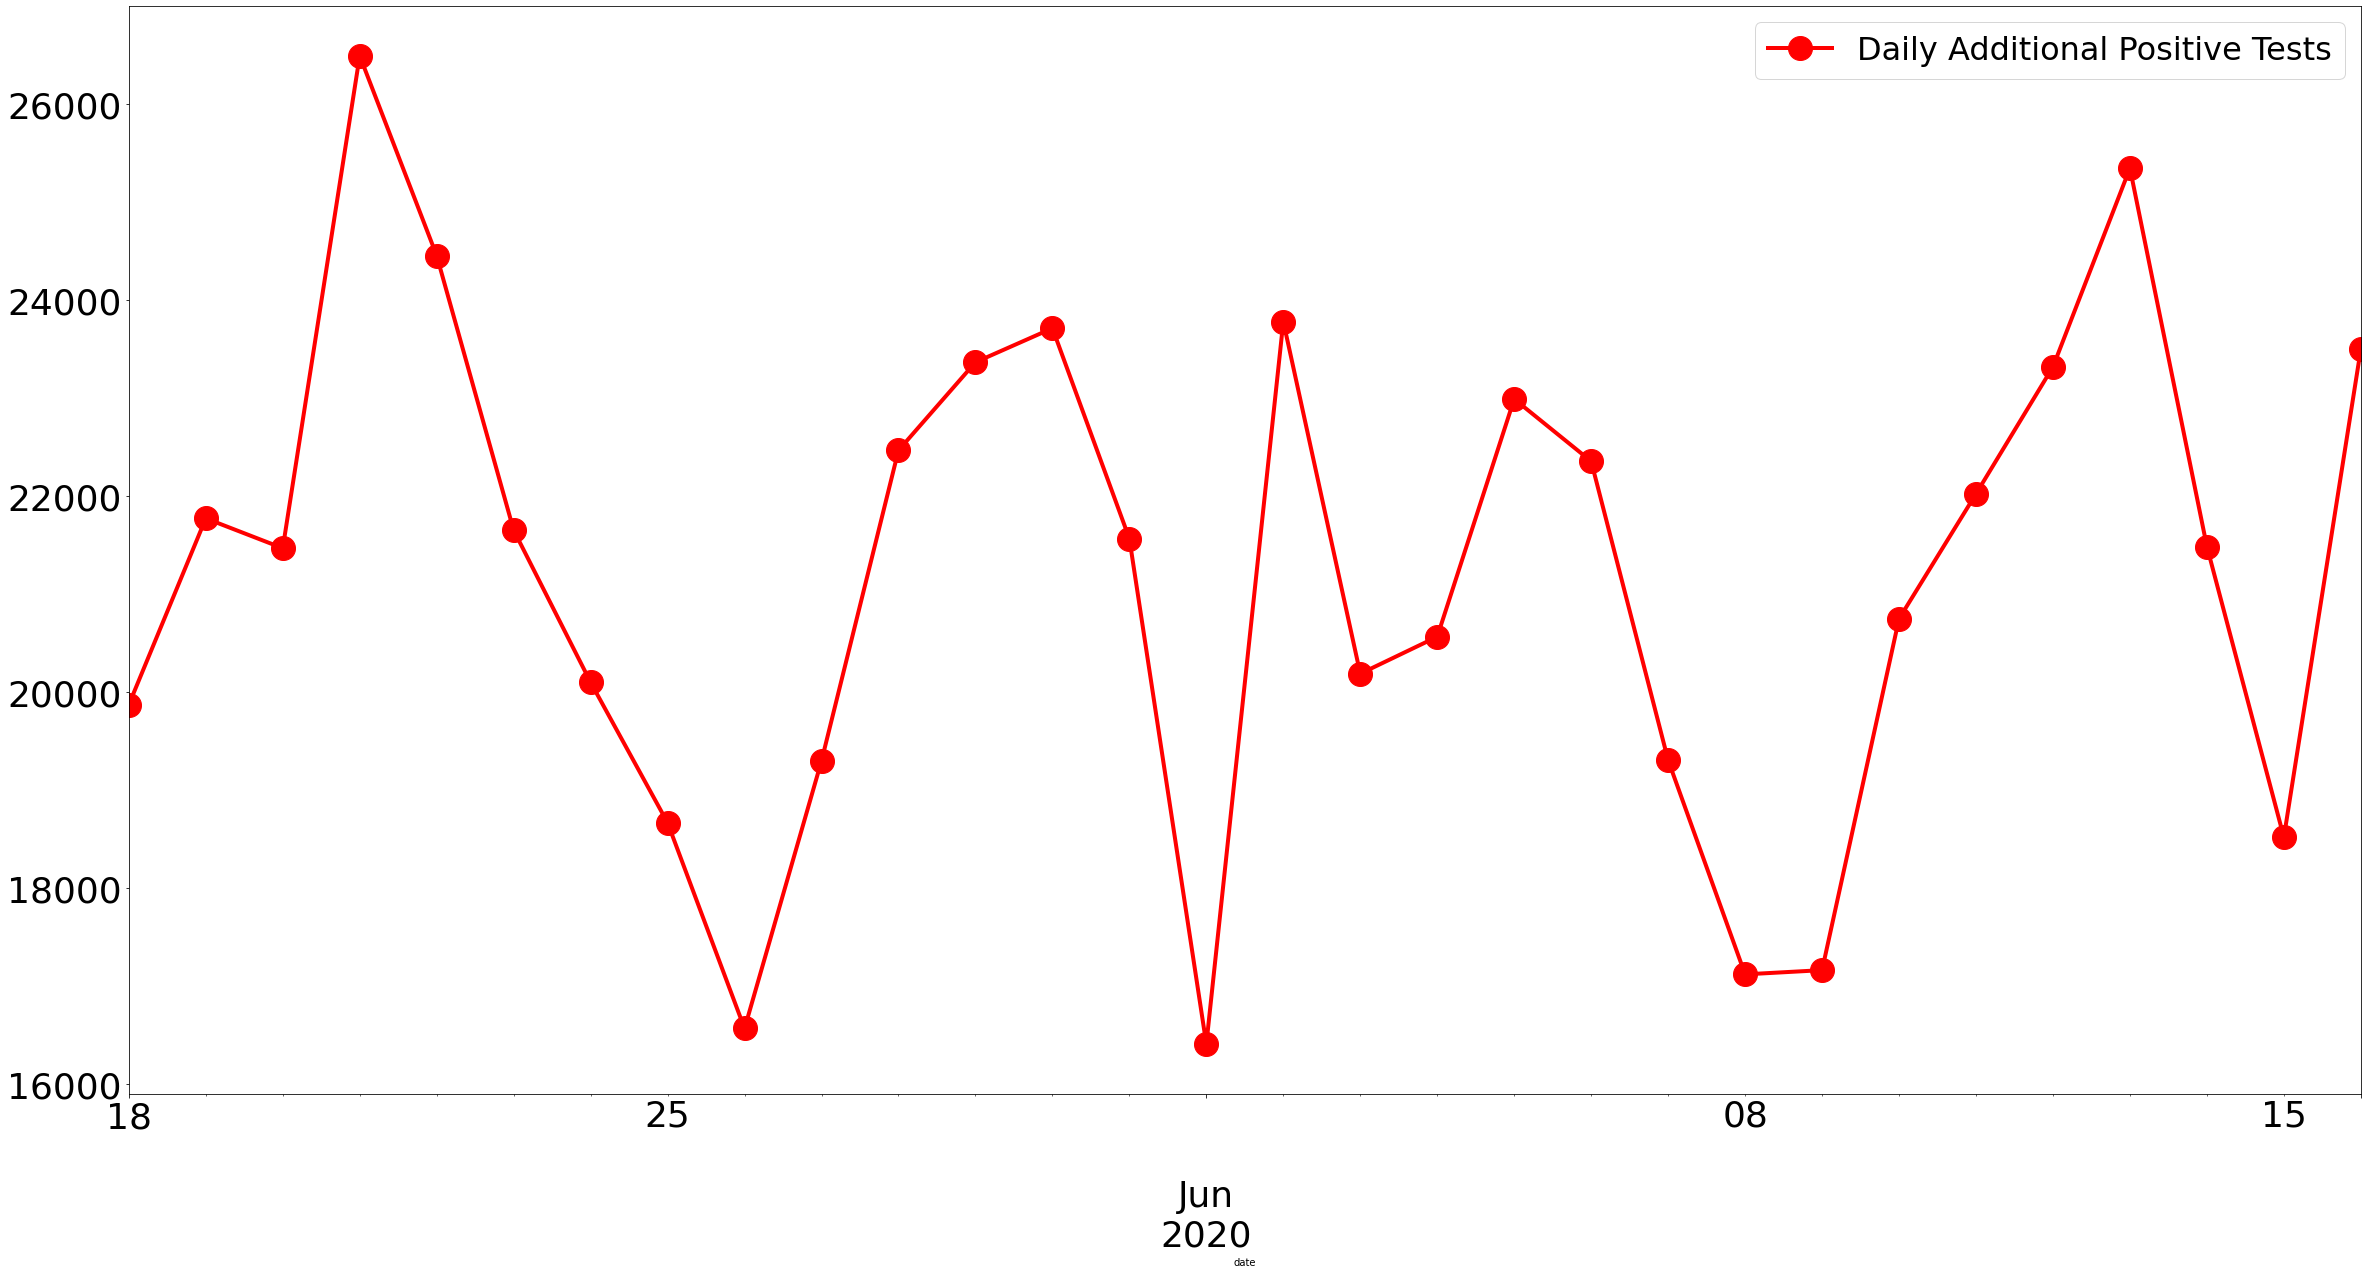

In [29]:
x = dfCovidtracking.groupby(by='date')
y1=x.sum()

chart = y1[-30:].positiveIncrease.plot.line(figsize=(40,20), fontsize=36, \
  style='.-', markersize=48, color='red', linewidth=4) \
.legend(['Daily Additional Positive Tests'],fontsize=32)


In [30]:
def getWeek(dt):
  return (dt.year*100)+dt.week

dfByWeekYear = dfCovidtracking[['deathIncrease', 'hospitalizedIncrease', 'negativeIncrease','positiveIncrease','totalTestResultsIncrease']].groupby(by=getWeek)


In [31]:
def getWeek(dt):
  return (dt.year*100)+dt.week

dfDoW = dfCovidtracking[['deathIncrease', 'hospitalizedIncrease', 'negativeIncrease','positiveIncrease','totalTestResultsIncrease']].groupby(by=lambda x: x.dayofweek)


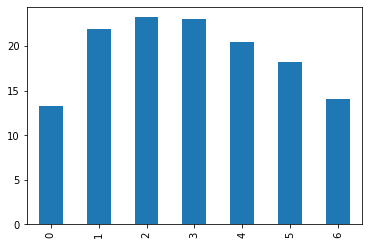

In [32]:
dfDoW.mean().deathIncrease.plot.bar()



In [33]:
dfByWeekYear.sum()[-7:]

,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
202019,12344,18998,1745965,171085,1917050
202020,9562,12129,2322288,158051,2480339
202021,7960,15648,2624204,155811,2780015
202022,6510,26480,2630569,145650,2776219
202023,5505,6823,3044485,145598,3190083
202024,5175,8155,3127772,147209,3274981
202025,1088,1865,872184,42019,914203


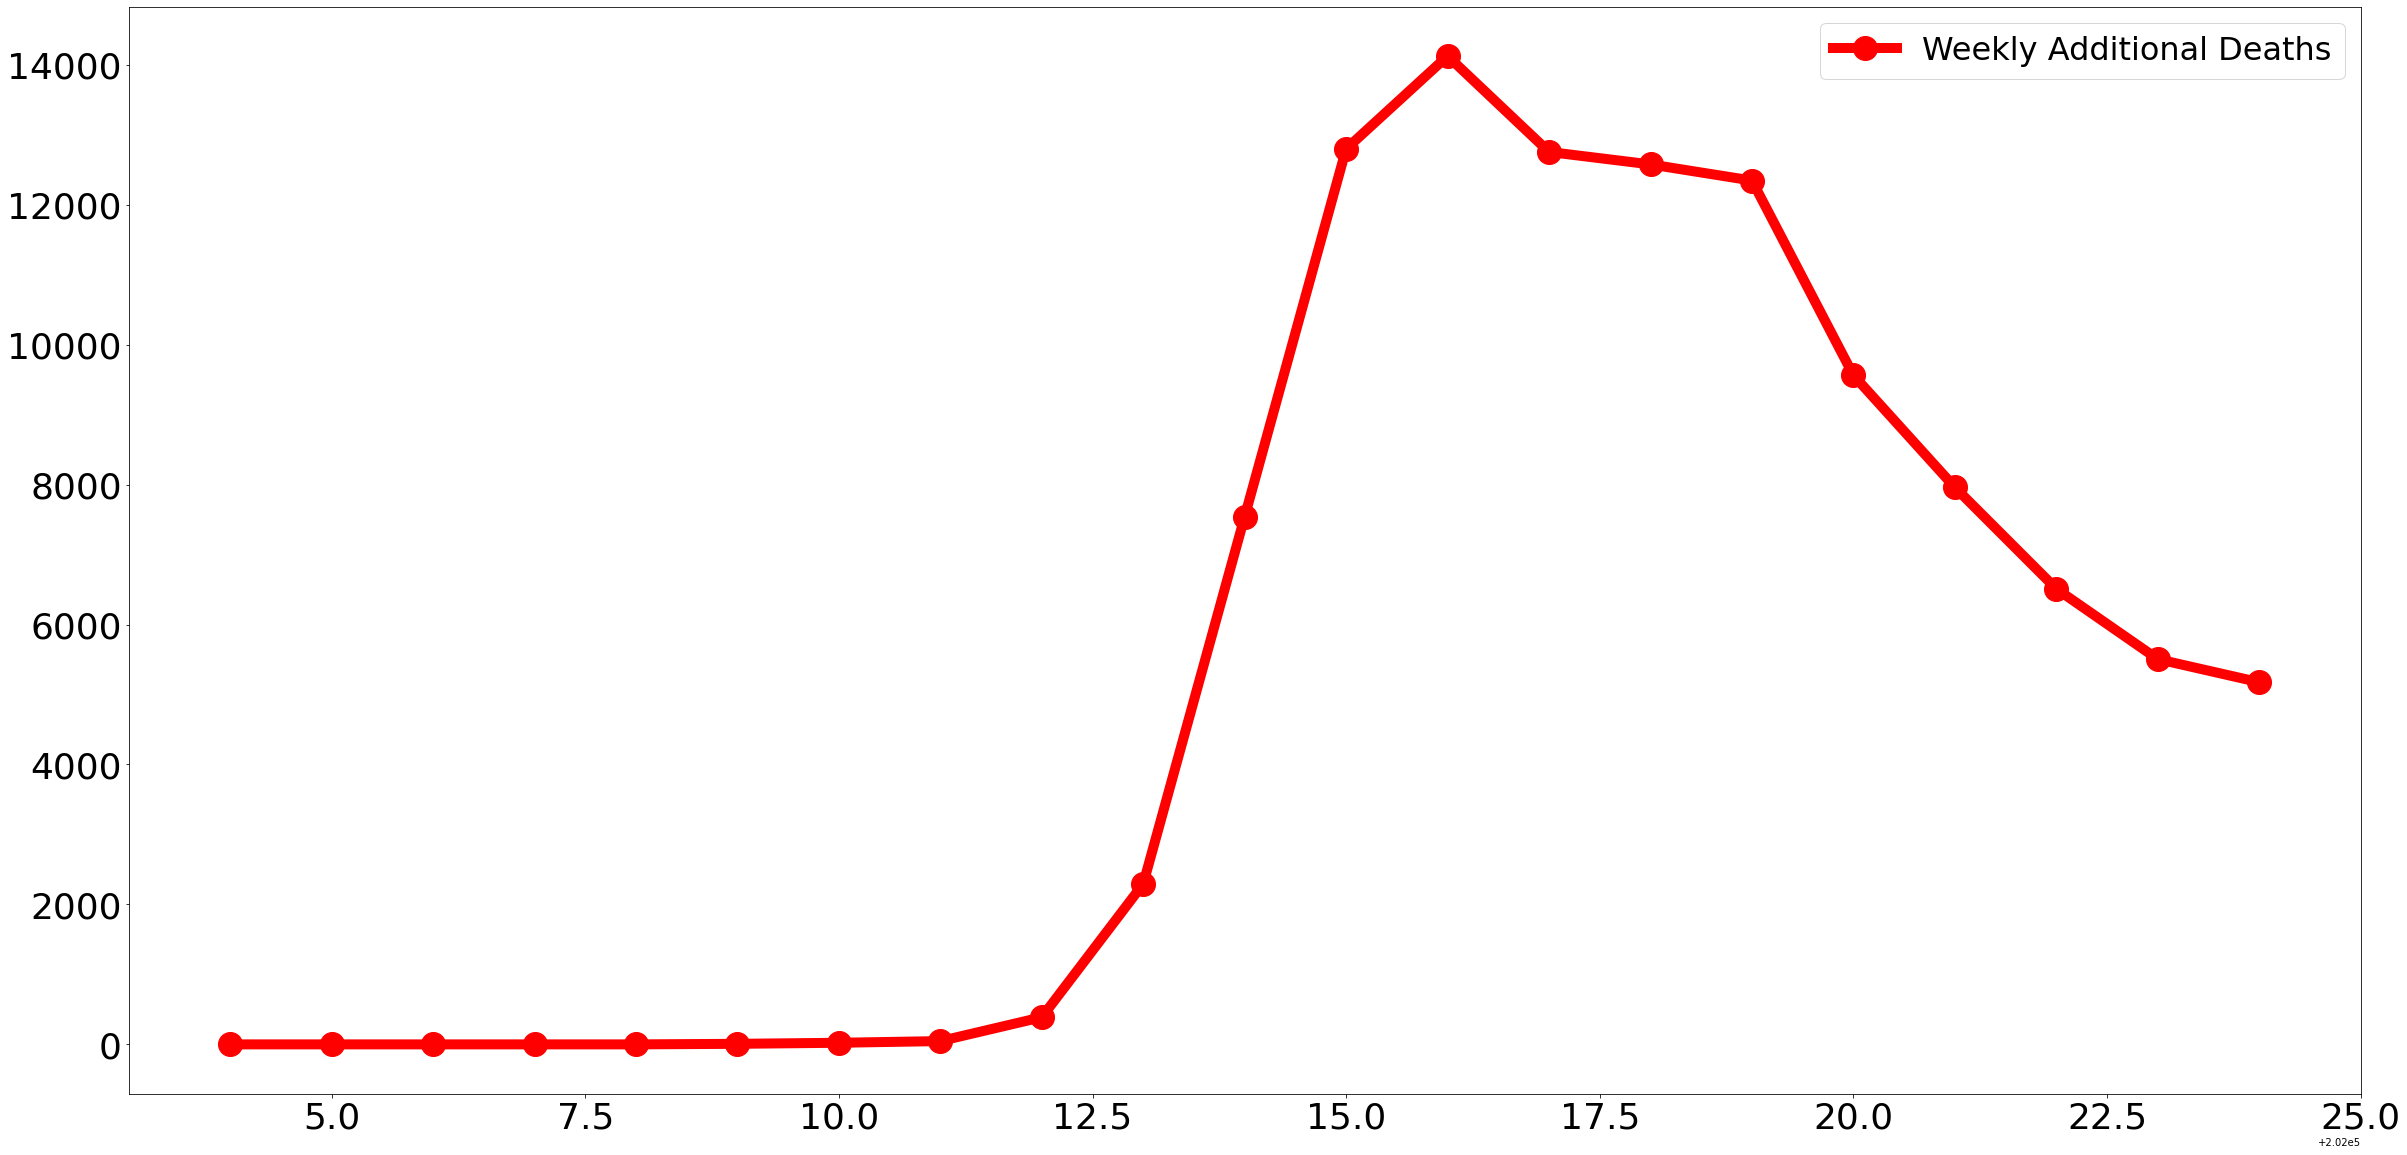

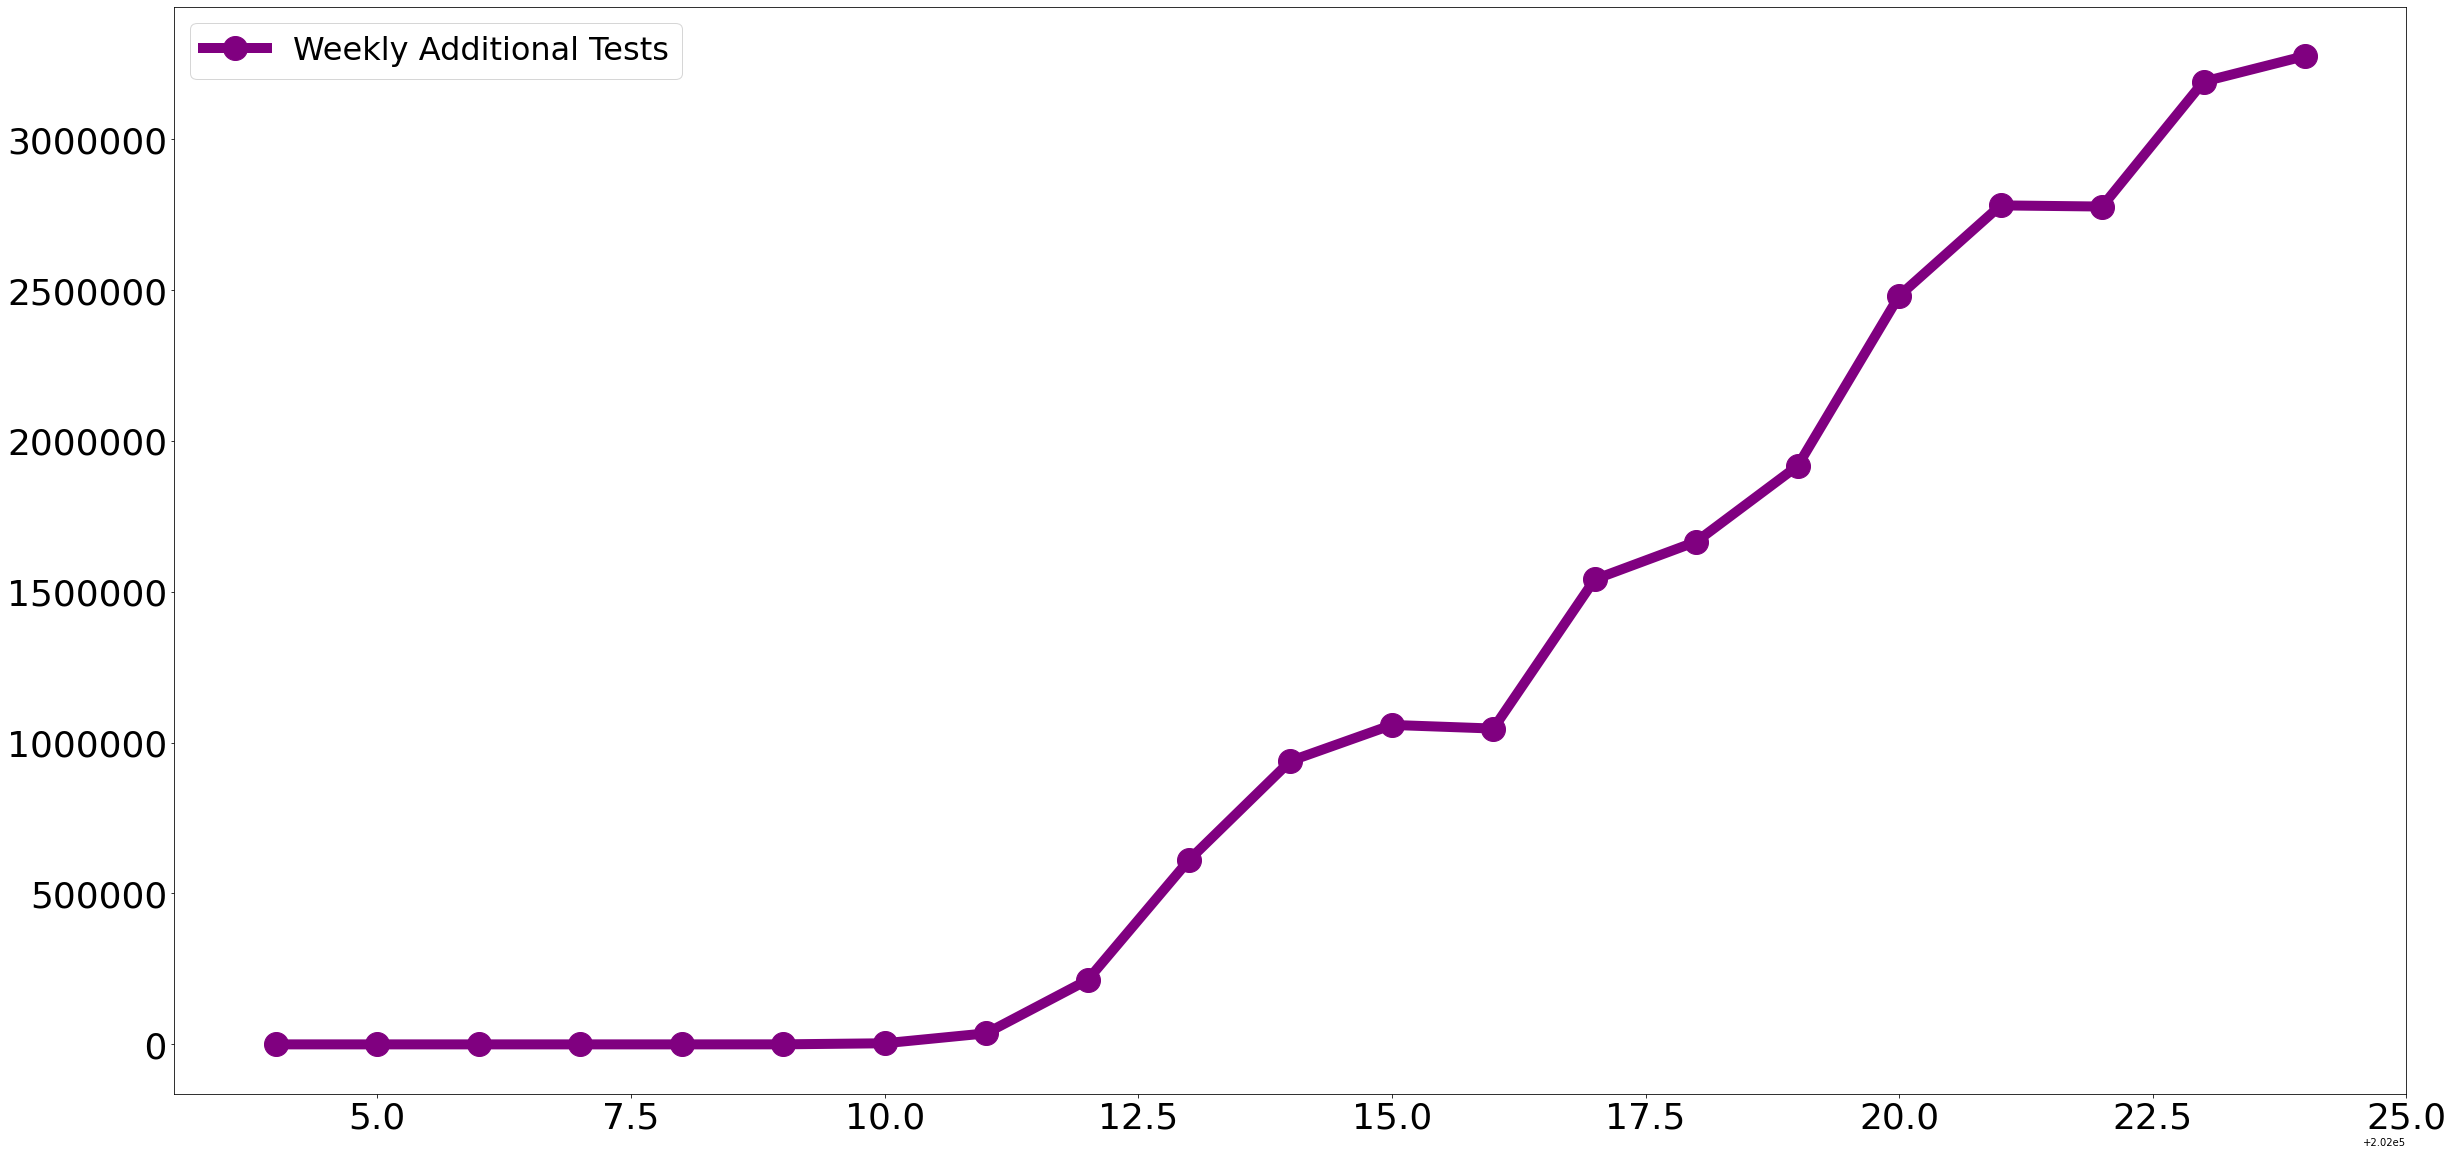

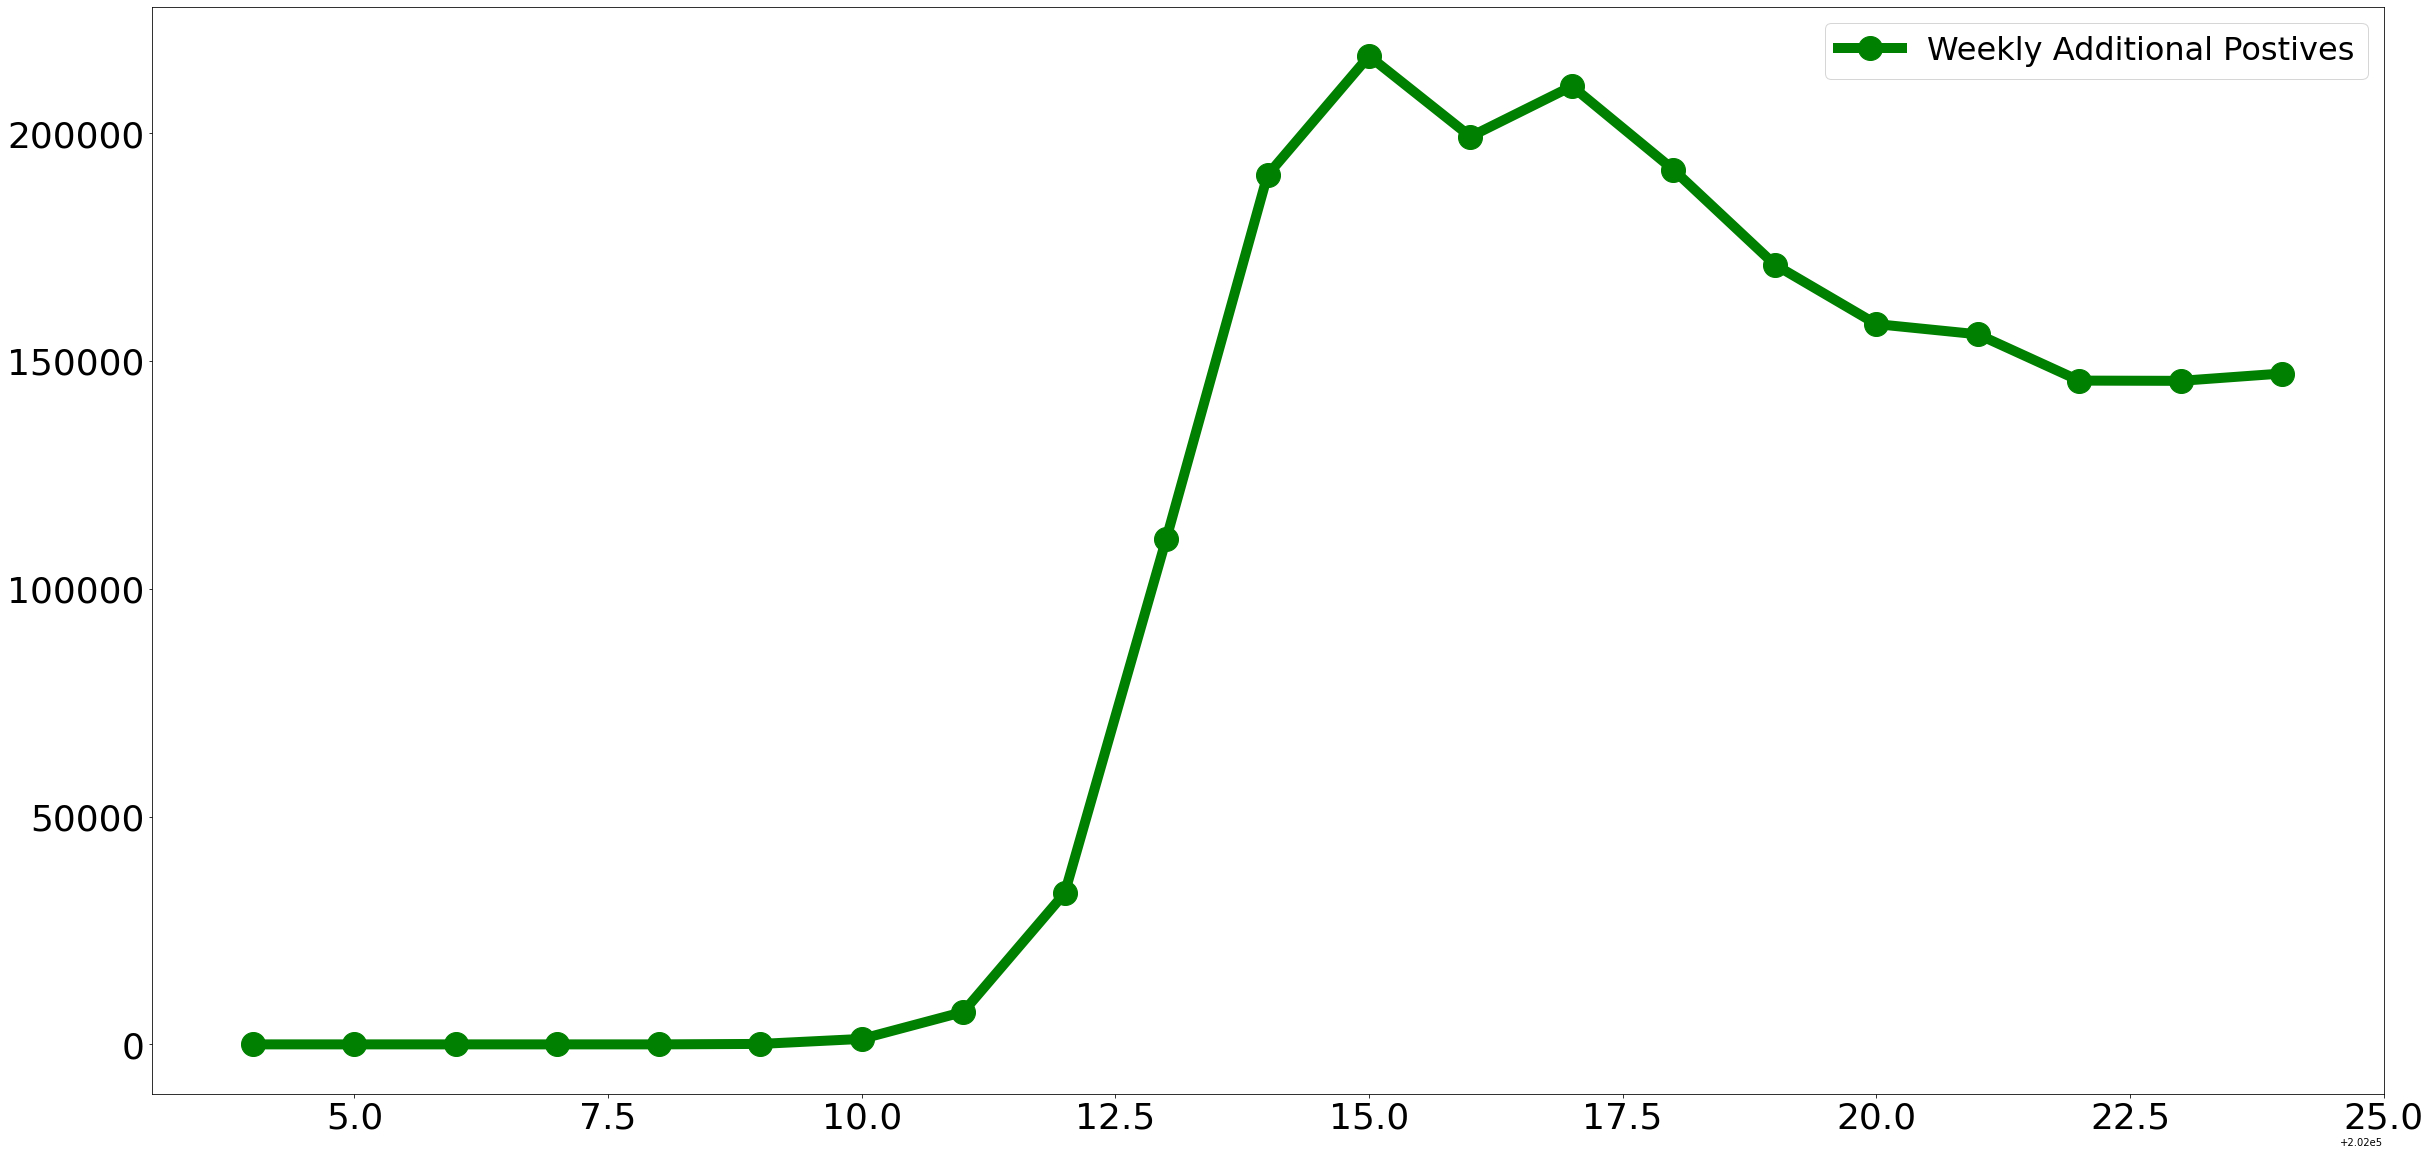

In [34]:
import matplotlib.ticker as ticker
plt1 = dfByWeekYear.sum()[:-1][['deathIncrease']].plot.line(figsize=(40,20), \
    fontsize=36, style='.-', markersize=48, linewidth=10, color='red')
plt1.legend(['Weekly Additional Deaths'],fontsize=32)
plt2 = dfByWeekYear.sum()[:-1][['totalTestResultsIncrease']].plot.line(figsize=(40,20), \
    fontsize=36, style='.-', markersize=48, linewidth=10, color='purple')
plt2.legend(['Weekly Additional Tests'],fontsize=32)

plt2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%6.0d'))
    
plt3 = dfByWeekYear.sum()[:-1][['positiveIncrease']].plot.line(figsize=(40,20), \
    fontsize=36, style='.-', markersize=48, linewidth=10, color='green')
plt3.legend(['Weekly Additional Postives'],fontsize=32)

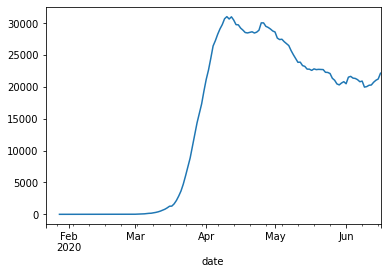

In [35]:
dfCovidtracking.groupby(by='date').sum().rolling(window=7).mean().positiveIncrease.plot.line()

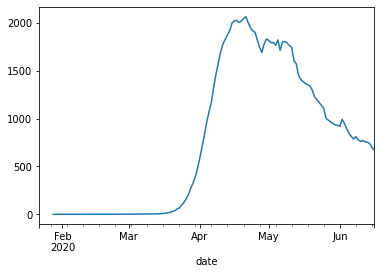

In [36]:
dfCovidtracking.groupby(by='date').sum().rolling(window=7).mean().deathIncrease.plot.line()

In [37]:
dfCAAvg = dfCovidtracking[dfCovidtracking.state=='OK'] \
.groupby(by='date').sum().rolling(window=7).mean()

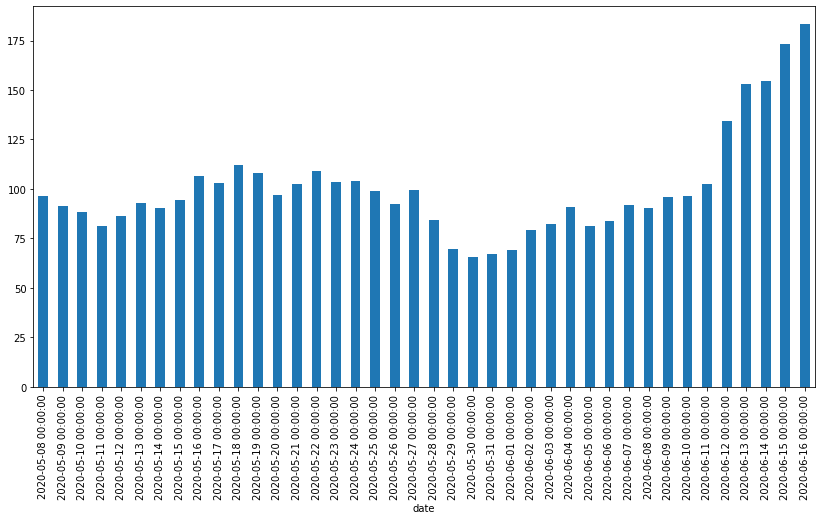

In [38]:

graph1 = dfCAAvg[-40:].positiveIncrease.plot.bar(figsize=(14,7))


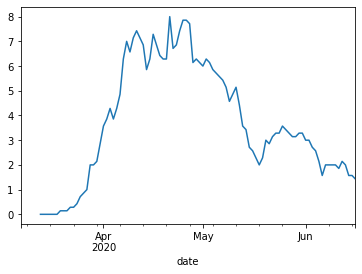

In [39]:
dfCAAvg.deathIncrease.plot.line()

In [40]:
dfDates = dfState.reset_index().copy()
dfDates[(dfDates.state.isin(['GA']))].head(10)

,state,date,positive,death,total_positive,pct
1129,GA,2020-06-16,59078,2529,59078,1.000000
1130,GA,2020-06-15,58414,2494,59078,0.988761
1131,GA,2020-06-14,57681,2451,59078,0.976353
1132,GA,2020-06-13,56801,2446,59078,0.961458
1133,GA,2020-06-12,55783,2418,59078,0.944226
1134,GA,2020-06-11,54973,2375,59078,0.930516
1135,GA,2020-06-10,53980,2329,59078,0.913707
1136,GA,2020-06-09,53249,2285,59078,0.901334
1137,GA,2020-06-08,52497,2208,59078,0.888605
1138,GA,2020-06-07,51898,2180,59078,0.878466


In [41]:
datecutoff = dfDates.date.max()-datetime.timedelta(days=7)
dfDates[(dfDates.date == datecutoff) & (dfDates.pct < .85)].sort_values(by='pct')


,state,date,positive,death,total_positive,pct
408,AZ,2020-06-09,28296,1070,39097,0.723738
4517,SC,2020-06-09,15228,568,19990,0.761781
212,AR,2020-06-09,10080,161,13191,0.764157
110,AL,2020-06-09,21422,729,26912,0.796002
3070,NC,2020-06-09,37160,1029,45853,0.810416
4108,OR,2020-06-09,4988,169,6098,0.817973
1031,FL,2020-06-09,66000,2851,80109,0.823877
4828,TX,2020-06-09,77253,1853,93206,0.828841
4933,UT,2020-06-09,12559,127,14937,0.840798
7,AK,2020-06-09,573,11,676,0.847633


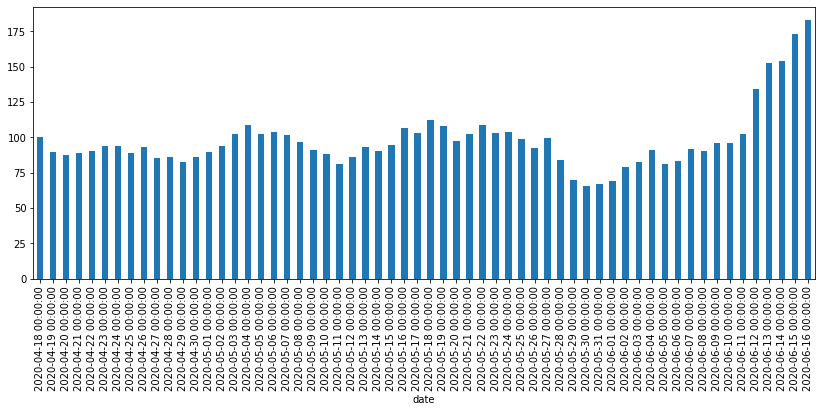

In [42]:

def showStateData(state):
  return dfCovidtracking[dfCovidtracking.state==state]\
  .sort_index()\
  .copy()



chart = showStateData('OK')\
.positiveIncrease\
.rolling(window=7)\
.mean()[-60:].plot.bar(figsize=(14,5))

In [43]:
dfTest = dfCovidtracking[dfCovidtracking.state=='CA'].sort_index().copy()
dfTest.head()

,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,dateModified,checkTimeEt,death,hospitalized,dateChecked,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,fips,positiveIncrease,negativeIncrease,total,totalTestResults,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-04,CA,53,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,0,0,0,0.0,0,515.0,0.0,0.0,0.0,06,0,0,515,515,0,515,0,0,9dbb0cfa2760f27838746d02e8fc099789ae3f1a,0,0,0,0,0,
2020-03-05,CA,53,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,0,0,0,0.0,0,515.0,0.0,0.0,0.0,06,0,0,515,515,0,515,0,0,5eb14913b30bcf9ea053d59682b69da30da6abd3,0,0,0,0,0,
2020-03-06,CA,60,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,0,0,0,0.0,0,522.0,0.0,0.0,0.0,06,7,0,522,522,7,522,0,0,8e5ed74c30d3fb109da2059a93acf92f06791e40,0,0,0,0,0,
2020-03-07,CA,69,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,0,0,0,0.0,0,531.0,0.0,0.0,0.0,06,9,0,531,531,9,531,0,0,0b7d9930019716fc386ce18aec0e08a3a60db668,0,0,0,0,0,
2020-03-08,CA,88,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,0,0,0,0.0,0,550.0,0.0,0.0,0.0,06,19,0,550,550,19,550,0,0,7ab4a572c391398447d11b5414f831e79f56c952,0,0,0,0,0,


In [44]:
dfTest.head()

,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,dateModified,checkTimeEt,death,hospitalized,dateChecked,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,fips,positiveIncrease,negativeIncrease,total,totalTestResults,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-04,CA,53,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,0,0,0,0.0,0,515.0,0.0,0.0,0.0,06,0,0,515,515,0,515,0,0,9dbb0cfa2760f27838746d02e8fc099789ae3f1a,0,0,0,0,0,
2020-03-05,CA,53,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,0,0,0,0.0,0,515.0,0.0,0.0,0.0,06,0,0,515,515,0,515,0,0,5eb14913b30bcf9ea053d59682b69da30da6abd3,0,0,0,0,0,
2020-03-06,CA,60,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,0,0,0,0.0,0,522.0,0.0,0.0,0.0,06,7,0,522,522,7,522,0,0,8e5ed74c30d3fb109da2059a93acf92f06791e40,0,0,0,0,0,
2020-03-07,CA,69,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,0,0,0,0.0,0,531.0,0.0,0.0,0.0,06,9,0,531,531,9,531,0,0,0b7d9930019716fc386ce18aec0e08a3a60db668,0,0,0,0,0,
2020-03-08,CA,88,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,0,0,0,0.0,0,550.0,0.0,0.0,0.0,06,19,0,550,550,19,550,0,0,7ab4a572c391398447d11b5414f831e79f56c952,0,0,0,0,0,


# State Population Data


In [45]:
data_url = "https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv"


In [46]:
dfUSPop = pd.read_csv(data_url)

In [47]:
import math
us_pop = dfUSPop.loc[0].POPESTIMATE2019 #Estimate from Wikipedia
res = dfCovidtracking.loc[dfCovidtracking.index.max()][['positive', 'negative', 'pending','death', 'total']].sum()
cir = res.positive/res.total
cfr = res.death/res.positive
p_aff= math.ceil(us_pop*cir)
p_dead= math.ceil(p_aff*cfr)
print(res)
print(f"Current Infection Rate {cir*100:2f}%")
print(f"Percentage of US affected: {(res.positive+res.death)/us_pop*100:2f}%")
print(f"Observed CFR: {cfr*100:2f}%")
print(f"Percentage of US tested/affected: {(res.negative+res.positive+res.death)/us_pop*100:2f}%")
print(f"Projected affected by cir = {p_aff:,d}")
print(f"Projected killed = {p_dead:,d}")


positive     2127047
negative    22322260
pending         1604
death         110695
total       24450911
dtype: int64
Current Infection Rate 8.699255%
Percentage of US affected: 0.681741%
Observed CFR: 5.204163%
Percentage of US tested/affected: 7.482341%
Projected affected by cir = 28,554,392
Projected killed = 1,486,018


In [48]:
!if [ ! -d "loc" ]; then \
git clone https://gist.github.com/rogerallen/1583593 --depth=1 --quiet loc; \
fi
import sys
sys.path.append("loc")




In [49]:
import us_state_abbrev as us_abbr


In [50]:
dfStatePop = dfUSPop[dfUSPop.STATE != 0].copy()

In [51]:
dfStatePop['ABBR']=dfStatePop.NAME.apply(lambda x: us_abbr.us_state_abbrev[x])

In [52]:
dfStatePop = dfStatePop.loc[:, ['ABBR', 'POPESTIMATE2019']]
dfStatePop.set_index('ABBR', inplace=True)

In [53]:
dfStateCovid = dfCovidtracking.loc[dfCovidtracking.index.max()].set_index('state')

In [54]:
dfStateJoin = dfStateCovid.join(dfStatePop)

In [55]:
pd.DataFrame([(dfStateJoin.positive / dfStateJoin.POPESTIMATE2019)*100, \
              (dfStateJoin.totalTestResults/ dfStateJoin.POPESTIMATE2019)*100],\
             index=['state_pos_pop','state_test_pop'] ).\
             T.sort_values(by="state_pos_pop", ascending=False)[:50]

,state_pos_pop,state_test_pop
state,,
NY,1.976887,15.687503
NJ,1.884963,12.742150
MA,1.536234,10.499045
RI,1.525825,19.220832
DC,1.391146,9.511314
CT,1.271959,10.137192
DE,1.068329,8.839308
IL,1.061410,9.700279
MD,1.032291,7.099698


In [56]:
#print(f"Current Infection Rate {res.positive/res.total*100:2f}%")

print(f"Current Testing Percent {gbUSA.sum().tail(1).totalTestResults[0]/dfUSPop[dfUSPop.REGION=='0'].POPESTIMATE2019[0]*100:2f}%")

Current Testing Percent 7.448618%


In [57]:
dfJHUData.columns

Index(['FIPS', 'city', 'state', 'country', 'last_update', 'lat', 'lon',
       'confirmed', 'dead', 'recovered', 'active', 'key'],
      dtype='object')

# OWID Data

In [58]:
dfOwid = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")

In [59]:
dfOwidTests = dfOwid.dropna(subset=['total_tests']).copy()

In [60]:
dfOwidLatest = dfOwidTests.sort_values(by='date').groupby('iso_code').last()

In [61]:
dfOwidLatest.total_tests.sort_values(ascending=False)

iso_code
USA    23290724.0
RUS    15161152.0
IND     5774133.0
DEU     4694147.0
ITA     4620718.0
          ...    
PRY       48081.0
BOL       47372.0
MDV       32127.0
CRI       24042.0
ZWE       24010.0
Name: total_tests, Length: 85, dtype: float64

In [62]:
isUSA = dfOwidLatest.index.isin(['USA'])
NonUSTests = dfOwidLatest[~isUSA].total_tests.sum()
USTests = dfOwidLatest[isUSA].total_tests.sum()

print(f"Total testing done outside of USA: {NonUSTests:.0f}")
print(f"Total tests done in USA : {USTests:.0f}")
print(f"How many more times has the world tested more than the US: {NonUSTests/USTests:.1f}")

Total testing done outside of USA: 71208360
Total tests done in USA : 23290724
How many more times has the world tested more than the US: 3.1


In [63]:
dfOwidLatest[isUSA].sum()

continent                            North America
location                             United States
date                                    2020-06-12
total_cases                            2.02335e+06
new_cases                                    22883
total_deaths                                113820
new_deaths                                     896
total_cases_per_million                    6112.78
new_cases_per_million                       69.132
total_deaths_per_million                   343.864
new_deaths_per_million                       2.707
total_tests                            2.32907e+07
new_tests                                   871843
total_tests_per_thousand                    70.364
new_tests_per_thousand                       2.634
new_tests_smoothed                          415125
new_tests_smoothed_per_thousand              1.254
tests_units                        tests performed
stringency_index                             72.69
population                     

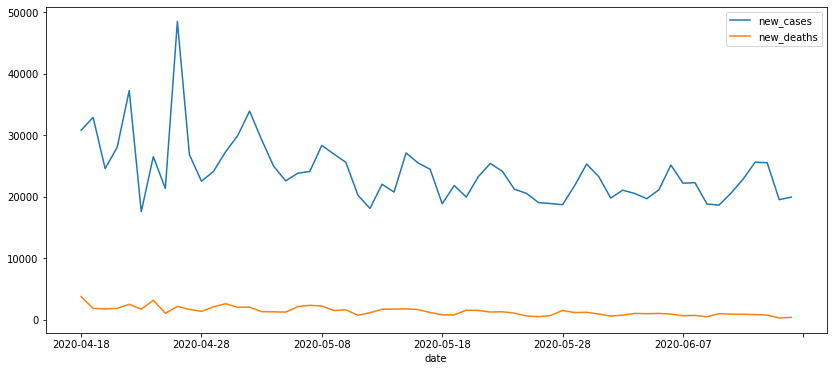

In [64]:
dfOwidUSA = dfOwid.loc[dfOwid.iso_code=='USA']

dfOwidUSA.set_index('date')[['new_cases','new_deaths']][-60:].plot.line(figsize=(14,6))

In [65]:
state = 'TX'
dfRollingWeekState = dfCovidtracking.loc[dfCovidtracking.state==state]\
.rolling(window=7).mean()


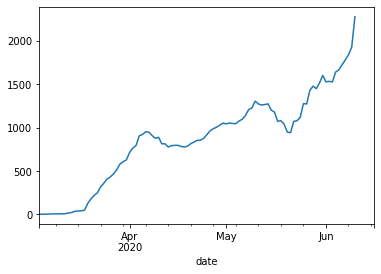

In [66]:
plt = dfRollingWeekState.positiveIncrease.plot.line()

In [67]:
dfJHUData[dfJHUData.state=='Florida'].confirmed.sum()

75568

In [68]:
doWGA = dfCovidtracking[dfCovidtracking.state=='GA'][['deathIncrease', 'hospitalizedIncrease', 'negativeIncrease','positiveIncrease','totalTestResultsIncrease']]\
.groupby(lambda x: x.dayofweek)

In [69]:
doWGA.sum()

,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,389,1211,94418,7147,101565
1,578,1981,76906,9534,86440
2,415,1953,1832,9366,11198
3,395,1367,76270,8411,84681
4,379,1421,98849,9782,108631
5,231,1154,102210,7672,109882
6,142,367,125415,7164,132579


# Socrata (San Francisco) Data

In [70]:
!pip install sodapy

In [71]:
from sodapy import Socrata

In [72]:
client = Socrata("data.sfgov.org", "LCSuN5PrqWkGtBe9dULkS75Rz")
results_df = pd.DataFrame.from_records(client.get("tvq9-ec9w"))

In [73]:
res = results_df.astype({'case_count':'int16'}).rename(columns={'specimen_collection_date':'date'})


In [74]:
dfresConf = res[res.case_disposition=='Confirmed']
dfresDead = res[res.case_disposition=='Death']

In [75]:
dfTotals = dfresConf.groupby(by='date').sum().join(dfresDead.groupby(by='date').sum(), \
        rsuffix='dead').fillna(0) \
        .rename(columns={'case_count':'positive', 'case_countdead':'dead'})

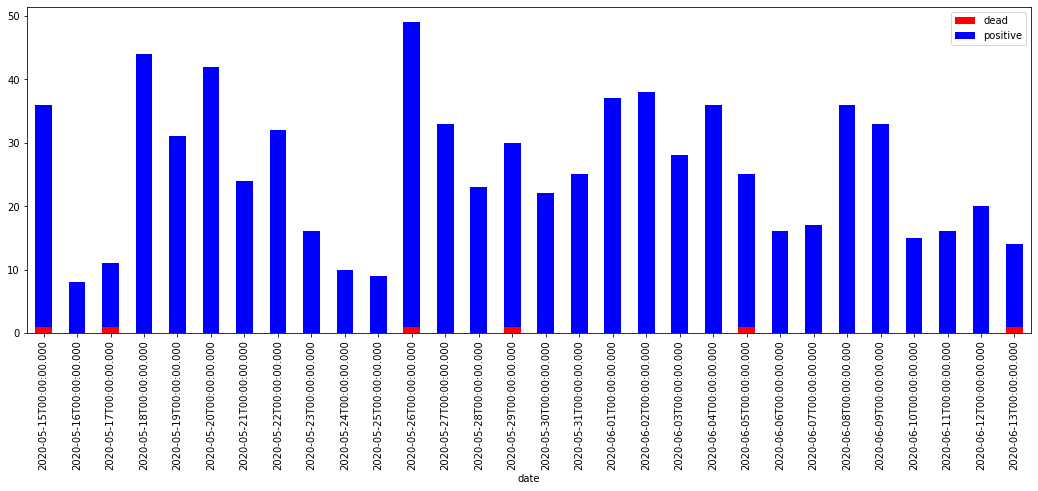

In [76]:
chart = dfTotals[['dead', 'positive']][-30:]\
.plot.bar(figsize=(18,6),stacked=True, color=['red','blue'])

In [77]:
dfresConf.groupby('date').sum().rename(columns={'case_count':'new_cases'}).tail(14)

,new_cases
date,
2020-05-31T00:00:00.000,25
2020-06-01T00:00:00.000,37
2020-06-02T00:00:00.000,38
2020-06-03T00:00:00.000,28
2020-06-04T00:00:00.000,36
2020-06-05T00:00:00.000,24
2020-06-06T00:00:00.000,16
2020-06-07T00:00:00.000,17
2020-06-08T00:00:00.000,36


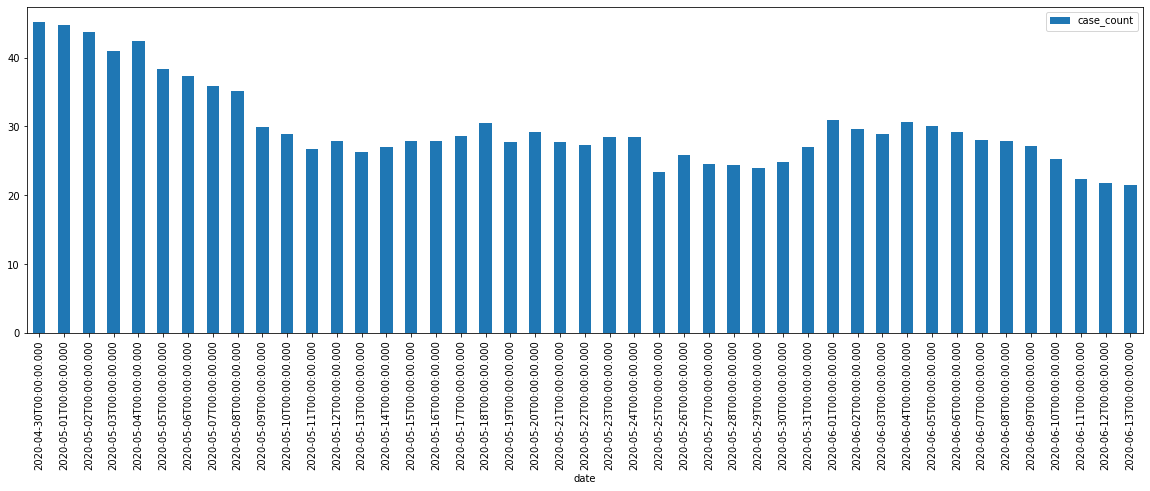

In [78]:
dfresConf.groupby('date').sum().rolling(window=7).mean()[-45:].plot.bar(figsize=(20,6))

# Marin Data

In [79]:
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSRmO2pStf7Ft1yYjDULluZXzUAczGK_B34hDemDBadGEY0HTLwlcadF2cHNEwmmvLetUTf-D2ruYCT/pub?gid=0&single=true&output=csv"

df = pd.read_csv(url, header=1, parse_dates=[0], usecols=[0,1,3,5,6,7], index_col=[0])

In [80]:
df.tail()

,positive,deaths,tested,hospitalizations,Recovered
date,,,,,
2020-06-11,648,17.0,17367.0,49.0,463.0
2020-06-12,676,17.0,17425.0,51.0,487.0
2020-06-13,697,17.0,18636.0,51.0,493.0
2020-06-14,714,17.0,19027.0,51.0,490.0
2020-06-15,725,17.0,19660.0,51.0,499.0


In [81]:
df[['deaths','positive','tested']].diff()[-14:]

,deaths,positive,tested
date,,,
2020-06-02,2.0,5.0,39.0
2020-06-03,0.0,19.0,639.0
2020-06-04,0.0,5.0,162.0
2020-06-05,0.0,21.0,442.0
2020-06-06,0.0,20.0,539.0
2020-06-07,0.0,18.0,389.0
2020-06-08,0.0,21.0,78.0
2020-06-09,0.0,10.0,508.0
2020-06-10,0.0,15.0,484.0


In [82]:
print(df[['deaths','positive','tested']].diff()[-14:].mean())
print(df[['deaths','positive','tested']].diff()[-14:].std())

deaths        0.142857
positive     16.000000
tested      422.000000
dtype: float64
deaths        0.534522
positive      6.575011
tested      305.614136
dtype: float64


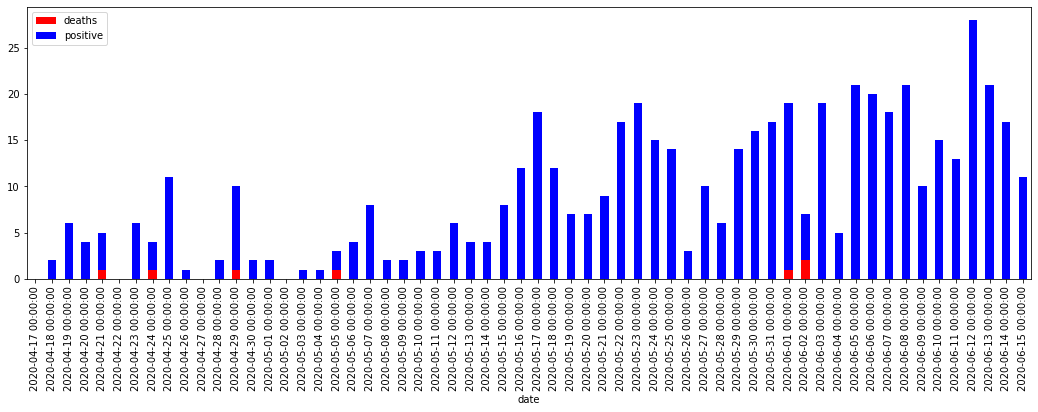

In [83]:
chart= df[['deaths','positive']].diff()[-60:]\
.plot.bar(stacked=True,figsize=(18,5), color=['r','b'])

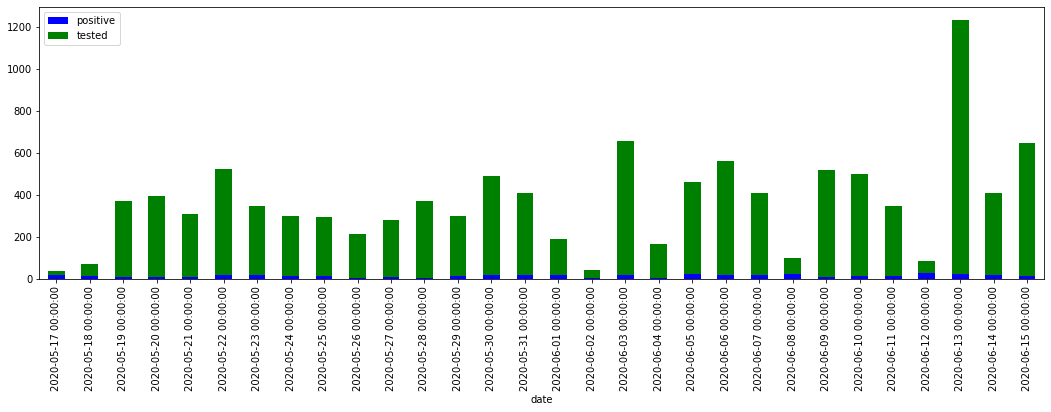

In [84]:
chart= df[['positive','tested']].diff()[-30:]\
.plot.bar(stacked=True,figsize=(18,5), color=['b','g'])

In [85]:
(df.positive.diff()/df.tested.diff()).rolling(window=7).mean()[-14:]

date
2020-06-02    0.058908
2020-06-03    0.057825
2020-06-04    0.059880
2020-06-05    0.059625
2020-06-06    0.060103
2020-06-07    0.060534
2020-06-08    0.084132
2020-06-09    0.068629
2020-06-10    0.068809
2020-06-11    0.069943
2020-06-12    0.132121
2020-06-13    0.129298
2020-06-14    0.128899
2020-06-15    0.092920
dtype: float64

In [86]:
df.positive.diff()[-1]/df.tested.diff()[-1]

0.017377567140600316

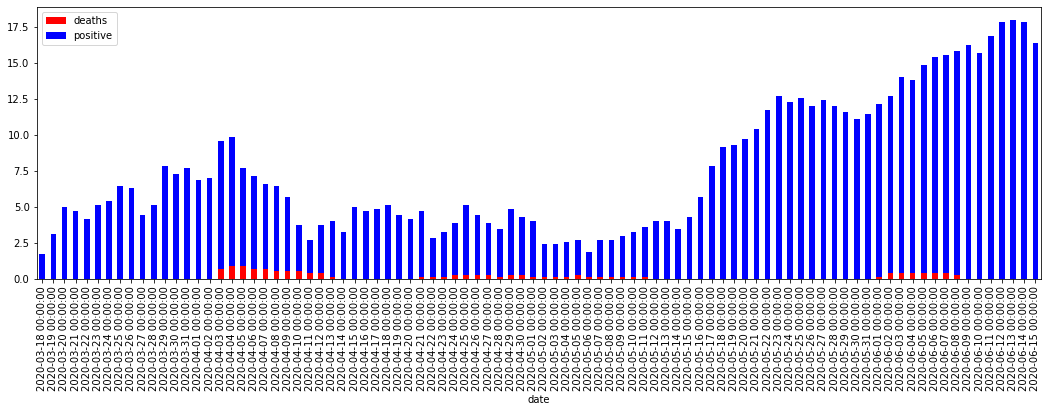

In [87]:
chart= df[['deaths','positive']].diff()\
.rolling(window=7).mean()[-90:]\
.plot.bar(stacked=True,figsize=(18,5), color=['r','b'])

In [88]:
marin_pop = 259725

print(f"Marin Population Positive: {(df[-1:].positive.values[0]/marin_pop)*100:2.2f}%")
print(f"Marin Population Tested: {(df[-1:].tested.values[0]/marin_pop)*100:2.2f}%")

Marin Population Positive: 0.28%
Marin Population Tested: 7.57%


In [89]:
df.positive.diff().rolling(window=7).mean().tail()

date
2020-06-11    16.857143
2020-06-12    17.857143
2020-06-13    18.000000
2020-06-14    17.857143
2020-06-15    16.428571
Name: positive, dtype: float64

In [90]:
dfCovidtracking[dfCovidtracking.state=='CA'].head(28)[::-1].positive.diff().max()


3705.0